<h1><center>It’s Time to Make Some Crazy Money!</center></h1>
<h1><center>Predicting a NYC Taxi Trip Duration</center></h1>
*****

## Table of contents
1. [Feature Engineering](#features)
    1. [Distance](#distance)
    2. [Speed](#speed)
2. [Data Cleaning](#dataclean)
    1. [Five decimals precision](#precision)
    2. [Short trips](#shorttrips)
    3. [More unlikely short trips](#unlikelyshort)
    4. [Long trips](#longtrips)
    5. [More unlikely long trips](#unlikelylong)
    6. [High and low speed](#dropspeed)
    7. [Final clean](#finalclean)
    8. [Test data](#test)
3. [Save Data](#save)

### Loading libraries <a name="libraries"></a>
***
These are some of the libraries used for data feature engineering and data cleaning.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import folium

import operator
from decimal import Decimal
import timeit

from geopy.distance import vincenty

%matplotlib inline
%pylab inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (17.5, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
plt.style.use(['seaborn-white'])

Populating the interactive namespace from numpy and matplotlib


### Loading data <a name="acquire"></a>
***
The data was acquired from a Kaggle's Competition called [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration). The data has been previously modified in the [EDA notebook](https://github.com/emmpew/datascience/blob/master/capstone_project/exploratory_data_analysis.ipynb).

In [9]:
train = pd.read_csv('modified_train_data.csv',index_col=0)
test = pd.read_csv('modified_test_data.csv',index_col=0)

/Users/andrew/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Data content <a name="content"></a>
***
Let's look at the content of the data such as shape, columns, and summary statistics. 

In [10]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,...,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_latitude_decimal,pickup_longitude_decimal,dropoff_latitude_decimal,dropoff_longitude_decimal,pickup_datetime_day_of_week
0,id2875421,2.0,2016-03-14 17:24:55,2016-03-14 17:32:30,1.0,-73.982155,40.767937,-73.964630,40.765602,455.0,...,3.0,14.0,17.0,24.0,55.0,10,10,10,9,Monday
1,id2377394,1.0,2016-06-12 00:43:35,2016-06-12 00:54:38,1.0,-73.980415,40.738564,-73.999481,40.731152,663.0,...,6.0,12.0,0.0,43.0,35.0,10,10,10,10,Sunday
2,id3858529,2.0,2016-01-19 11:35:24,2016-01-19 12:10:48,1.0,-73.979027,40.763939,-74.005333,40.710087,2124.0,...,1.0,19.0,11.0,35.0,24.0,10,10,10,10,Tuesday
3,id3504673,2.0,2016-04-06 19:32:31,2016-04-06 19:39:40,1.0,-74.010040,40.719971,-74.012268,40.706718,429.0,...,4.0,6.0,19.0,32.0,31.0,10,10,10,10,Wednesday
4,id2181028,2.0,2016-03-26 13:30:55,2016-03-26 13:38:10,1.0,-73.973053,40.793209,-73.972923,40.782520,435.0,...,3.0,26.0,13.0,30.0,55.0,10,10,10,10,Saturday


In [11]:
train.shape

(1458644, 21)

In [12]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'store_and_fwd_flag_Y', 'pickup_month', 'pickup_day', 'pickup_hour',
       'pickup_minute', 'pickup_second', 'pickup_latitude_decimal',
       'pickup_longitude_decimal', 'dropoff_latitude_decimal',
       'dropoff_longitude_decimal', 'pickup_datetime_day_of_week'],
      dtype='object')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
id                             1458644 non-null object
vendor_id                      1458644 non-null float64
pickup_datetime                1458644 non-null object
dropoff_datetime               1458644 non-null object
passenger_count                1458644 non-null float64
pickup_longitude               1458644 non-null float64
pickup_latitude                1458644 non-null float64
dropoff_longitude              1458644 non-null float64
dropoff_latitude               1458644 non-null float64
trip_duration                  1458644 non-null float64
store_and_fwd_flag_Y           1458644 non-null float64
pickup_month                   1458644 non-null float64
pickup_day                     1458644 non-null float64
pickup_hour                    1458644 non-null float64
pickup_minute                  1458644 non-null float64
pickup_second                  1458644 non-null fl

# 1. Feature Engineering <a name='features'></a>
***
Some of the features that are in the dataset will be helpful to engineer features that will be more related to the duration of a trip.

### Distance <a name='distance'></a>
***
Latitude and longitude will help in the calculation of the distance of each trip. The distance feature will help our algorithm understand what kind of trip it is. The [geopy package](https://github.com/geopy/geopy) will help to get the geodensic distance between two points. This distance will be in a straight line meaning the minimum possible distance traveled by the taxi.

In [14]:
columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
distance = pd.DataFrame(train, columns=columns)
train['direct_distance'] = distance.apply((lambda s: vincenty((s[0],s[1]),(s[2],s[3])).miles),axis=1)

Text(0.5,1,'Relationship between distance and time')

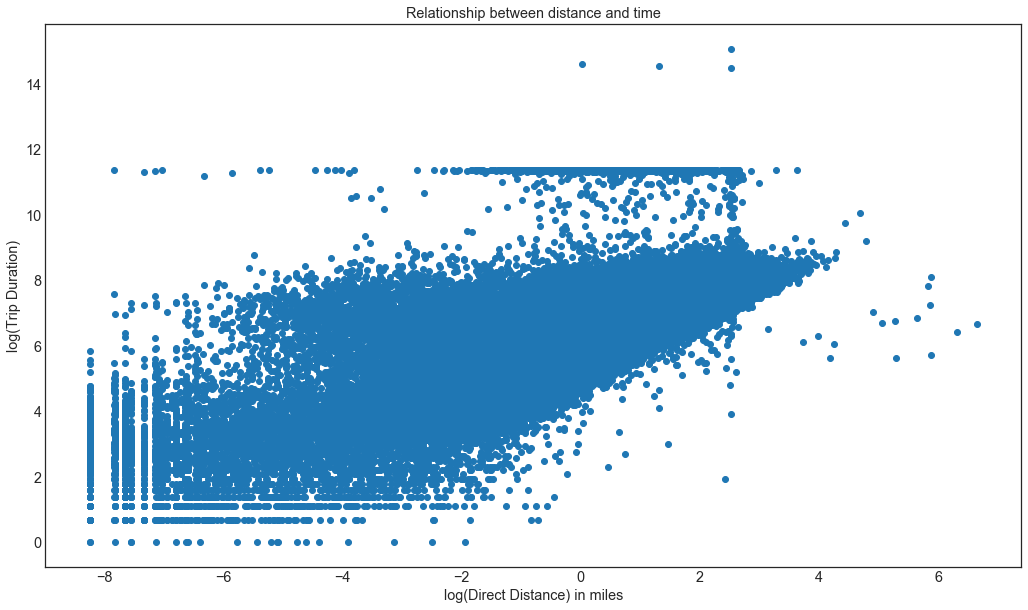

In [16]:
plt.scatter(np.log(train[train['direct_distance']>0]['direct_distance']), np.log(train[train['direct_distance']>0]['trip_duration']))
plt.xlabel('log(Direct Distance) in miles')
plt.ylabel('log(Trip Duration)')
plt.title("Relationship between distance and time")

The graph shows a linear relationship between duration and distance. 

- The higher distance will be longer in duration.
- Some trips have a high trip_duration and low direct_distance.
- Also some trips show low trip_duration and high direct_distance.

### Speed <a name='speed'></a>
***
Calculating the speed of a trip will help remove errors in the data. 

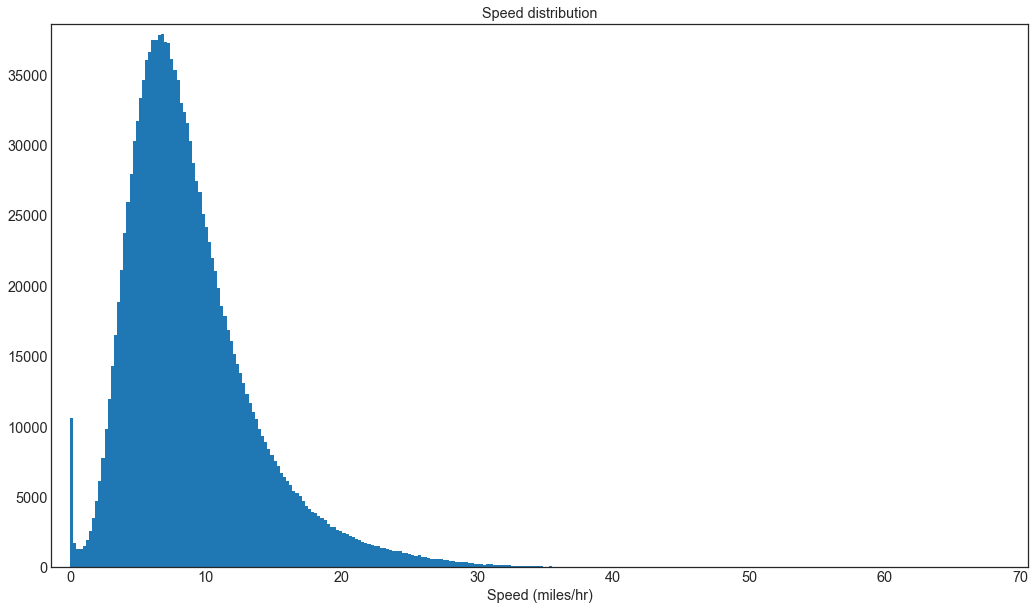

In [10]:
train['speed'] = train['direct_distance'] / (train['trip_duration']/3600)

plt.hist(train[(train['speed'] >= np.percentile(train['speed'],0.0)) & (train['speed'] <= np.percentile(train['speed'],99.99))]['speed'],bins=300)
plt.title('Speed distribution')
plt.xlabel('Speed (miles/hr)')
plt.margins(0.02)

After removing some of the extreme values of speed, the graph looks pretty reasonable. The average speed of most trips is aroung 8 miles per hour which makes sense for a city. However, we see a fairly high amount of trips with speed of 0. 

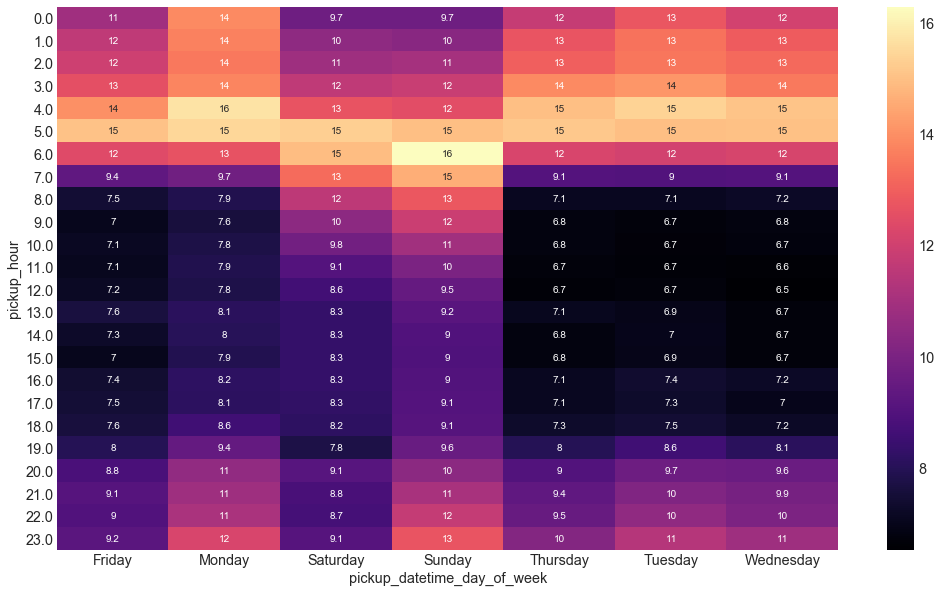

In [11]:
pvtrain = train.pivot_table(values='speed',index='pickup_hour',columns='pickup_datetime_day_of_week')
sns.heatmap(pvtrain,annot= True,cmap='magma')

- Trips at 5 AM have higher speed due to less traffic.
- During the week the speed looks like almost the same between 8 AM and 6 PM.

# 2. Data Cleaning <a name='dataclean'></a>
***
EDA helped to visualize and have a good understanding of the data. The aim here is to remove trips that are unlikely to happen, such as low and high duration times. Removing the inconsistent data will help our model have a better performance. Let's look at some of the cases found thanks to EDA.

### Five decimals precision <a name='precision'></a>
***
First let's make sure we only work with five decimal precision latitude and longitudes. If they have more, we only use 5 decimals; if they have less, we drop them.

In [12]:
columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
drop_index = train[(train['pickup_latitude_decimal'] <= 4) | (train['pickup_longitude_decimal'] <= 4) | 
          (train['dropoff_latitude_decimal'] <= 4) | (train['dropoff_longitude_decimal'] <= 4)].index
train.drop(index=drop_index,inplace=True)

After dropping the trips with a low precision, let's round down all of the other trips to 5 decimals which is a precision of 1.1 meters.

In [13]:
train[columns] = train[columns].round(5)

### Short trips <a name='shorttrips'></a>
***
Some trips have a duration of a few seconds or zero that will be checked to make sure they are realistic. 

In [14]:
cols = ['trip_duration','direct_distance','speed','passenger_count']
train[train['direct_distance']==0][cols].describe()

,trip_duration,direct_distance,speed,passenger_count
count,5897.000000,5897.0,5897.0,5897.000000
mean,535.515347,0.0,0.0,1.689842
std,1952.094051,0.0,0.0,1.382786
min,1.000000,0.0,0.0,0.000000
25%,38.000000,0.0,0.0,1.000000
50%,350.000000,0.0,0.0,1.000000
75%,724.000000,0.0,0.0,2.000000
max,86352.000000,0.0,0.0,9.000000


It shows that for trips with 0 direct_distance there are some trip_durations with values of 1 to 86352 seconds. Staying in a taxi for a long time does not make sense. However, staying in a taxi for  a few seconds and not moving might not be unusual if the customer decides to cancel the trip after a few seconds.

Let's drop the trips with direct_distance of 0 and trip_duration of more than 60 seconds.

In [15]:
drop_index = train[(train['direct_distance']==0) & (train['trip_duration']>60)].index
train.drop(index=drop_index,inplace=True)

### More unlikely short trips <a name='unlikelyshort'></a>
***
Let's remove short trips that do not have a reasonable speed of less than 65 mph and also long distances in a 5 minute trip_duration.

In [16]:
train[(train['direct_distance']>0) & (train['trip_duration']<5*60)][cols].sort_values('direct_distance',ascending=False).head()

,trip_duration,direct_distance,speed,passenger_count
377068,282.0,199.115417,2541.898942,1.0
595540,279.0,65.258490,842.045033,1.0
500725,184.0,13.494229,264.017518,1.0
793555,268.0,12.529145,168.301949,1.0
906281,51.0,12.417285,876.514227,1.0


The data shows that some of the speeds are impossible. Most of the direct_distance seem to be short which is expected in a trip of 5 minutes. However, there are a few that have high direct_distance in only 5 minutes that do not make sense. So let's drop anything that is above 65 mph.

In [17]:
drop_index = train[(train['direct_distance']>0) & (train['trip_duration']<5*60) & (train['speed']>65)].index
train.drop(index=drop_index,inplace=True)

### Long trips <a name='longtrips'></a>
***
Let's look at trips high trip_durations.

In [18]:
long_trips = train[(train['trip_duration']>8*3600) & (train['direct_distance']<120)]
long_trips[cols].sort_values('direct_distance',ascending=False).head(10)

,trip_duration,direct_distance,speed,passenger_count
900381,85561.0,37.607921,1.582362,5.0
1097636,85828.0,26.318473,1.103911,1.0
944061,58583.0,19.776656,1.215301,1.0
1259412,85102.0,17.494599,0.740060,5.0
794471,65550.0,15.296399,0.840077,2.0
255361,74524.0,15.058028,0.727402,1.0
938669,32338.0,15.031839,1.673407,1.0
1327210,82134.0,14.156802,0.620504,1.0
652867,85347.0,14.136849,0.596303,5.0
59438,83926.0,14.131892,0.606187,5.0


These are trips that lasted more than 8 hours with a direct distance of less than 120 miles. It sounds unreasonable to do a direct distance of 37 miles in 8 hours but just to make sure lets see on map where these top 10 trips are.

In [19]:
s = []
for index, row in long_trips[['pickup_longitude','pickup_latitude', 'dropoff_latitude', 'dropoff_longitude']].iterrows():
    s.append([[row['pickup_latitude'], row['pickup_longitude']] , [row['dropoff_latitude'], row['dropoff_longitude']]])
    
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=10,
                        tiles="CartoDB dark_matter")
for i in range(len(s)):
    folium.PolyLine(s[i],color='yellow',weight=1.0,opacity=0.7).add_to(folium_map)

folium_map

The longest trip seems to be from Manhattan to upstate New York which according to [Google Maps](https://www.google.com/maps/dir/'41.28180,-74.07554'/40.73991,-73.99873/@41.0220824,-74.3331175,10z/data=!3m1!4b1!4m6!4m5!1m3!2m2!1d-74.07554!2d41.2818!1m0) the correct distance is 47 miles (increases by 10 miles compared to our direct_distance) and still the trip_duration is only roughly 1 hour. This means the trip_duration is completely off and we can safely drop all of these trips.

In [20]:
drop_index = long_trips.index
train.drop(index=drop_index,inplace=True)

### More unlikely long trips <a name='unlikelylong'></a>
***
Some of the direct_distance of the trips are pretty high making no sense to take a taxi. 

In [21]:
more_long = train[train['direct_distance']>120]
more_long[cols].sort_values('direct_distance',ascending=False).head(10)

,trip_duration,direct_distance,speed,passenger_count
184925,792.0,770.817336,3503.715165,1.0
974378,611.0,554.054184,3264.476371,5.0
910072,303.0,359.512785,4271.439035,2.0
1100676,3267.0,357.661419,394.117266,2.0
923793,1405.0,349.849395,896.411260,1.0
397526,2515.0,339.843123,486.455364,2.0
1013474,933.0,283.572028,1094.168595,1.0
275644,875.0,195.272499,803.406853,4.0
644165,804.0,157.820751,706.660079,1.0
1060807,1131.0,133.912510,426.246715,1.0


In [22]:
s = []
for index, row in more_long[['pickup_longitude','pickup_latitude', 'dropoff_latitude', 'dropoff_longitude']].iterrows():
    s.append([[row['pickup_latitude'], row['pickup_longitude']] , [row['dropoff_latitude'], row['dropoff_longitude']]])
    
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=6,
                        tiles="CartoDB dark_matter")
for i in range(len(s)):
    folium.PolyLine(s[i],color='yellow',weight=1.0,opacity=0.7).add_to(folium_map)

folium_map

All of these trips look unsual. Some of them are on the water. The trip_duration is low for large distances and highly doubt that anyone would take a taxi for 770 miles. Let's drop all of these and look at trips longer than one hour.

In [23]:
drop_index = more_long.index
train.drop(index=drop_index,inplace=True)

Some of the data has high trip_duration with low direct_distance. Let's check any that is above 1 hour and direct_distance of less than 5 miles.

In [24]:
long_duration = train[(train['trip_duration']>3600) & (train['direct_distance']<3)]
long_duration[cols].sort_values('trip_duration',ascending=False).head()

,trip_duration,direct_distance,speed,passenger_count
906364,28325.0,1.955294,0.248510,2.0
499910,28241.0,0.291419,0.037148,5.0
838811,27064.0,1.492013,0.198465,5.0
544098,27047.0,2.023561,0.269339,1.0
425755,26396.0,0.210142,0.028660,1.0


In [25]:
s = []
for index, row in long_duration[['pickup_longitude','pickup_latitude', 'dropoff_latitude', 'dropoff_longitude']].iterrows():
    s.append([[row['pickup_latitude'], row['pickup_longitude']] , [row['dropoff_latitude'], row['dropoff_longitude']]])
    
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="CartoDB dark_matter")
for i in range(len(s)):
    folium.PolyLine(s[i],color='yellow',weight=1.0,opacity=0.7).add_to(folium_map)

folium_map

All of the trips are in Manhattan. Certainly it can happen that 3 miles can take more than one hour, but it will be an extreme case. So let's drop all of these trips.

In [26]:
drop_index = long_duration.index
train.drop(index=drop_index,inplace=True)

### High and low speed <a name='dropspeed'></a>
***
Some of the speeds are not believable. So let's make sure all of the trips are from taxis and not airplanes. Let's have in mind that the true speed of each trip is higher than the calculated speed used in our case since the direct_distance is the minimum distance between two points.

In [27]:
speed = train[train['speed']>60]
speed[cols].sort_values('speed',ascending=False).head(10)

,trip_duration,direct_distance,speed,passenger_count
283102,427.0,70.109248,591.084998,1.0
1359910,548.0,53.421126,350.941705,1.0
218935,461.0,41.384304,323.174610,6.0
656806,684.0,23.292438,122.591778,1.0
775976,317.0,9.874807,112.142920,2.0
587146,420.0,11.677500,100.092854,1.0
13046,355.0,9.404876,95.373386,1.0
1093421,355.0,8.832318,89.567163,1.0
573454,481.0,11.870606,88.844454,1.0
924243,551.0,12.526828,81.844977,1.0


In [28]:
drop_index = speed[speed['speed']>60].index  
train.drop(index=drop_index,inplace=True)                 

Dropped anything above 60 mph due to the fact that true speed should be higher and also most of the trips are inside Manhattan. Reaching an average trip of more than 60 mph in Manhattan sounds unreasonable. So let's work with that number for now.

Also, let's check unusual low speeds.

In [29]:
low_speed = train[(train['speed']<1) & (train['trip_duration']>1800)]
low_speed[cols].sort_values('direct_distance',ascending=False).head()

,trip_duration,direct_distance,speed,passenger_count
803459,26577.0,6.247888,0.846311,2.0
1238243,24155.0,6.140965,0.915234,3.0
844853,21411.0,5.533081,0.930320,2.0
1263976,18794.0,4.665892,0.893754,2.0
127198,20470.0,3.497705,0.615131,1.0


It sounds unreasonable to be in a taxi that goes less than a mile per hour for more than 1 hour. The average human can walk [3.1 miles per hour](https://en.wikipedia.org/wiki/Walking). However, since the direct_distance is in straight line, let's just drop anything above 30 minutes and speed of less than 1 mph.

In [30]:
drop_index = low_speed.index  
train.drop(index=drop_index,inplace=True)  

### Final Clean <a name='finalclean'></a>
***
Let's drop any column that will no be used for training and change any data type that we need to change.

In [31]:
# Convert to datetime object
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S') 
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

train['pickup_weekday'] = train['pickup_datetime'].dt.weekday.astype(float)

int_feat = train.dtypes[(train.dtypes != 'object') & (train.dtypes != 'float64') & (train.dtypes != 'datetime64[ns]')].index
train[int_feat] = train[int_feat].astype(float)

In [32]:
train.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_day', 'pickup_minute', 'pickup_second', 'pickup_latitude_decimal', 'pickup_longitude_decimal',
           'dropoff_latitude_decimal','dropoff_longitude_decimal','pickup_datetime_day_of_week','speed'],axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450268 entries, 0 to 1458643
Data columns (total 13 columns):
Unnamed: 0              1450268 non-null float64
vendor_id               1450268 non-null float64
passenger_count         1450268 non-null float64
pickup_longitude        1450268 non-null float64
pickup_latitude         1450268 non-null float64
dropoff_longitude       1450268 non-null float64
dropoff_latitude        1450268 non-null float64
trip_duration           1450268 non-null float64
store_and_fwd_flag_Y    1450268 non-null float64
pickup_month            1450268 non-null float64
pickup_hour             1450268 non-null float64
direct_distance         1450268 non-null float64
pickup_weekday          1450268 non-null float64
dtypes: float64(13)
memory usage: 154.9 MB


### Test data<a name='test'></a>
***
Let's make sure the test dataset is ready for testing the model.

- Get dummy variables
- Make sure all of the datatypes are floats.
- Add correlated features such as direct_distance
- Drop any coordinate that is not 5 decimals
- Round coordinates to 5 decimals

In [33]:
test = test.loc[:,'vendor_id':'store_and_fwd_flag']

# Convert to datetime object
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S') 

# get dummies
test = pd.get_dummies(test,drop_first=True)

# Split datetime objects to separte columns
test['pickup_month'] = test['pickup_datetime'].dt.month.astype(float)
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday.astype(float)
test['pickup_hour'] = test['pickup_datetime'].dt.hour.astype(float)

# # Convert to Float datatype
int_feat = test.dtypes[(test.dtypes != 'object') & (test.dtypes != 'float64') & (test.dtypes != 'datetime64[ns]')].index
test[int_feat] = test[int_feat].astype(float)

test.drop(labels=['pickup_datetime'],axis=1,inplace=True)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 10 columns):
vendor_id               625134 non-null float64
passenger_count         625134 non-null float64
pickup_longitude        625134 non-null float64
pickup_latitude         625134 non-null float64
dropoff_longitude       625134 non-null float64
dropoff_latitude        625134 non-null float64
store_and_fwd_flag_Y    625134 non-null float64
pickup_month            625134 non-null float64
pickup_weekday          625134 non-null float64
pickup_hour             625134 non-null float64
dtypes: float64(10)
memory usage: 47.7 MB


In [34]:
columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
distance = pd.DataFrame(test, columns=columns)
test['direct_distance'] = distance.apply((lambda s: vincenty((s[0],s[1]),(s[2],s[3])).miles),axis=1)

In [35]:
for index, each in enumerate(columns):
    s = test[each].astype(str)
    test[each + '_decimal'] = s.apply(lambda x: abs(Decimal(x).as_tuple().exponent))

drop_index = test[(test['pickup_latitude_decimal'] <= 4) | (test['pickup_longitude_decimal'] <= 4) | 
          (test['dropoff_latitude_decimal'] <= 4) | (test['dropoff_longitude_decimal'] <= 4)].index
test.drop(index=drop_index,inplace=True)

In [36]:
test[columns] = test[columns].round(5)
test.drop(labels=['pickup_latitude_decimal','pickup_longitude_decimal','dropoff_latitude_decimal','dropoff_longitude_decimal'],axis=1,inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624841 entries, 0 to 625133
Data columns (total 11 columns):
vendor_id               624841 non-null float64
passenger_count         624841 non-null float64
pickup_longitude        624841 non-null float64
pickup_latitude         624841 non-null float64
dropoff_longitude       624841 non-null float64
dropoff_latitude        624841 non-null float64
store_and_fwd_flag_Y    624841 non-null float64
pickup_month            624841 non-null float64
pickup_weekday          624841 non-null float64
pickup_hour             624841 non-null float64
direct_distance         624841 non-null float64
dtypes: float64(11)
memory usage: 57.2 MB


## 3. Save Data <a name="save"></a>
***
Distance and speed were the features engineered to help with data cleaning and modeling. The data was cleaned to improve the modeling results and lower the error. Let's save the data for further reference.

In [37]:
train.to_csv('cleaned_train_data.csv')

test.to_csv('cleaned_test_data.csv')

Now it is time to move on to the last notebook of this project [predictive modeling](https://github.com/emmpew/datascience/blob/master/capstone_project/predictive_modeling.ipynb).